In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
import imutils
import dlib # run "pip install dlib"
import cv2 # run "pip install opencv-python"

import imageio
from imutils import face_utils

In [ ]:
people = ['F01','F02','F04','F05','F06','F07','F08','F09', 'F10','F11','M01','M02','M04','M07','M08']
data_types = ['words']
folder_enum = ['01','02','03','04','05','06','07','08', '09', '10']
instances = ['01','02','03','04','05','06','07','08', '09', '10']

words = ['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']          
words_di = {i:words[i] for i in range(len(words))}

In [ ]:
os.listdir('/content/cropped/cropped')

['M04',
 'M07',
 'F02',
 'F06',
 'F11',
 'F07',
 'M01',
 'M08',
 'F01',
 'F09',
 'F05',
 'F08',
 'M02',
 'F04',
 'F10']

In [ ]:
max_seq_length = 22

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []


MAX_WIDTH = 100
MAX_HEIGHT = 100

In [ ]:
from skimage.transform import resize
import time

In [ ]:
t1 = time.time()
UNSEEN_VALIDATION_SPLIT = ['08']
UNSEEN_TEST_SPLIT = ['09','10']

directory = "/content/cropped/cropped"

for person_id in people:
    tx1 = time.time()
    for data_type in data_types:
        for word_index, word in enumerate(folder_enum):
#             print(f"Word : '{words[word_index]}'")
            for iteration in instances:
                path = os.path.join(directory, person_id, data_type, word, iteration)
                filelist = sorted(os.listdir(path + '/'))
                sequence = [] 
                for img_name in filelist:
                    if img_name.startswith('color'):
                        image = imageio.imread(path + '/' + img_name)
                        image = resize(image, (MAX_WIDTH, MAX_HEIGHT))
                        image = 255 * image
                        # Convert to integer data type pixels.
                        image = image.astype(np.uint8)
                        sequence.append(image)                        
                pad_array = [np.zeros((MAX_WIDTH, MAX_HEIGHT))]                            
                sequence.extend(pad_array * (max_seq_length - len(sequence)))
                sequence = np.array(sequence)
                                
                if iteration in UNSEEN_TEST_SPLIT:
                    X_test.append(sequence)
                    y_test.append(word_index)
                elif iteration in UNSEEN_VALIDATION_SPLIT:
                    X_val.append(sequence)
                    y_val.append(word_index)
                else:
                    X_train.append(sequence)
                    y_train.append(word_index)    
    tx2 = time.time()
    print(f'Finished reading images for person {person_id}. Time taken : {tx2 - tx1} secs.')    
    
t2 = time.time()
print(f"Time taken for creating constant size 3D Tensors from those cropped lip regions : {t2 - t1} secs.")

Finished reading images for person F01. Time taken : 2.6743483543395996 secs.
Finished reading images for person F02. Time taken : 2.623161554336548 secs.
Finished reading images for person F04. Time taken : 4.359957456588745 secs.
Finished reading images for person F05. Time taken : 3.5827951431274414 secs.
Finished reading images for person F06. Time taken : 3.86537766456604 secs.
Finished reading images for person F07. Time taken : 3.5985937118530273 secs.
Finished reading images for person F08. Time taken : 2.790574073791504 secs.
Finished reading images for person F09. Time taken : 2.9485490322113037 secs.
Finished reading images for person F10. Time taken : 2.5341110229492188 secs.
Finished reading images for person F11. Time taken : 2.9266104698181152 secs.
Finished reading images for person M01. Time taken : 3.0624682903289795 secs.
Finished reading images for person M02. Time taken : 3.5416274070739746 secs.
Finished reading images for person M04. Time taken : 3.20992302894592

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# print(X_train)
# print(X_val)
# print(X_test)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1050, 22, 100, 100)
(150, 22, 100, 100)
(300, 22, 100, 100)


In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1050,)
(150,)
(300,)


In [ ]:
def normalize_it(X):
    v_min = X.min(axis=(2, 3), keepdims=True)
    v_max = X.max(axis=(2, 3), keepdims=True)
    X = (X - v_min)/(v_max - v_min)
    X = np.nan_to_num(X)
    return X

In [ ]:
from keras.utils import np_utils, generic_utils

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
X_train = normalize_it(X_train)
X_val = normalize_it(X_val)
X_test = normalize_it(X_test)

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)
y_val = np_utils.to_categorical(y_val, 10)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

In [ ]:
X_train = np.expand_dims(X_train, axis=4)
X_val = np.expand_dims(X_val, axis=4)
X_test = np.expand_dims(X_test, axis=4)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1050, 22, 100, 100, 1)
(150, 22, 100, 100, 1)
(300, 22, 100, 100, 1)


In [ ]:
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.core import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop 

In [ ]:
# 1st layer group
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), strides = 1, input_shape=(22, 100, 100, 1), activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(64, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model.add(Conv3D(128, (3, 3, 3), activation='relu', strides=1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=2))

model(tf.keras.Input((22, 100, 100, 1)))
shape = model.get_output_shape_at(0)
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

# LSTMS - Recurrent Network Layer
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(.4))
# model.add(LSTM(128, return_sequences=True))

model.add((Flatten()))

# # FC layers group
model.add(Dense(2048, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.4))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 98, 98, 32)    896       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 49, 49, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 47, 47, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 23, 23, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 21, 21, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 10, 10, 128)  

In [ ]:
t1 = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=45, batch_size=25)
t2 = time.time()
print()
print(f"Training time : {t2 - t1} secs.")

Epoch 1/45
42/42 [==============================] - 24s 219ms/step - loss: 2.3010 - accuracy: 0.0876 - val_loss: 2.2891 - val_accuracy: 0.1467
Epoch 2/45
42/42 [==============================] - 8s 203ms/step - loss: 2.2805 - accuracy: 0.1400 - val_loss: 2.2566 - val_accuracy: 0.1800
Epoch 3/45
42/42 [==============================] - 9s 204ms/step - loss: 2.2597 - accuracy: 0.1619 - val_loss: 2.2094 - val_accuracy: 0.2667
Epoch 4/45
42/42 [==============================] - 9s 205ms/step - loss: 2.1359 - accuracy: 0.2229 - val_loss: 1.9310 - val_accuracy: 0.3533
Epoch 5/45
42/42 [==============================] - 9s 205ms/step - loss: 1.8254 - accuracy: 0.3152 - val_loss: 1.5826 - val_accuracy: 0.4667
Epoch 6/45
42/42 [==============================] - 9s 206ms/step - loss: 1.5138 - accuracy: 0.4438 - val_loss: 1.3295 - val_accuracy: 0.5133
Epoch 7/45
42/42 [==============================] - 9s 207ms/step - loss: 1.2367 - accuracy: 0.5476 - val_loss: 1.0450 - val_accuracy: 0.6467
Epoch

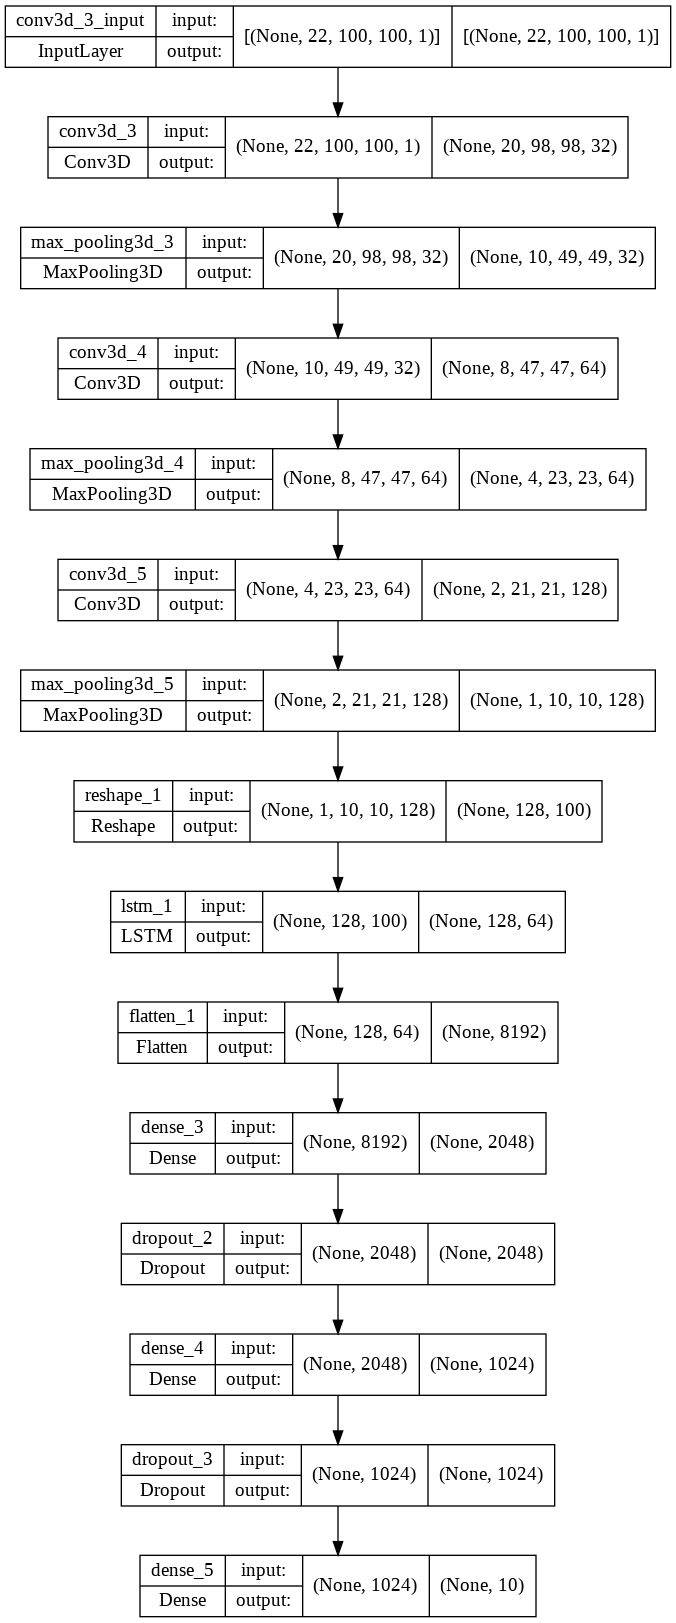

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

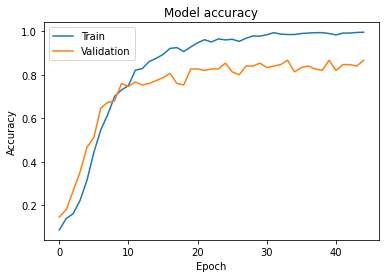

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

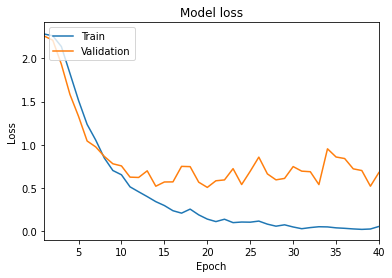

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(1, 40)
# plt.ylim(0, 3)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
ypred = model.predict(X_test)

In [ ]:
predicted_words = [words[i] for i in np.argmax(ypred, axis=1)]
actual_words = [words[i] for i in np.argmax(y_test, axis=1)] 

In [ ]:
correct = 0
for p, a in zip(predicted_words, actual_words):
    if p == a:
        correct += 1
    # print(f"Predicted : {p} \t Actual : {a}")

accuracy = correct/len(actual_words)
print(f"Accuracy = {accuracy}")

Accuracy = 0.85


In [ ]:
from sklearn import metrics
import seaborn as sn

In [ ]:
print(metrics.classification_report(actual_words, predicted_words,labels=['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']))

              precision    recall  f1-score   support

       Begin       0.86      0.80      0.83        30
      Choose       0.88      1.00      0.94        30
  Connection       0.89      0.80      0.84        30
  Navigation       0.77      1.00      0.87        30
        Next       0.84      0.90      0.87        30
    Previous       0.96      0.87      0.91        30
       Start       0.74      0.83      0.78        30
        Stop       0.79      0.90      0.84        30
       Hello       0.96      0.83      0.89        30
         Web       0.89      0.57      0.69        30

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

5/5 [==============================] - 1s 165ms/step - loss: 0.6936 - accuracy: 0.8667
Validation: accuracy = 0.866667  ;  loss_v = 0.693559
Test: accuracy = 0.850000  ;  loss = 0.593516


In [ ]:
from keras.models import save_model, load_model

# Creates a HDF5 file 'my_model.h5' 
save_model(model, '/content/drive/MyDrive/cnn_lstm_model.h5') # model, [path + "/"] name of model

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# new_model = load_model('my_model.h5')

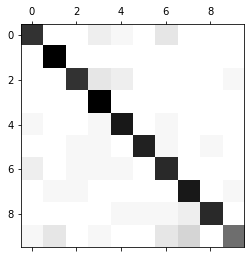

In [ ]:
cm= metrics.confusion_matrix(actual_words,predicted_words,labels=['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web'])
plt.matshow(cm,cmap='binary')

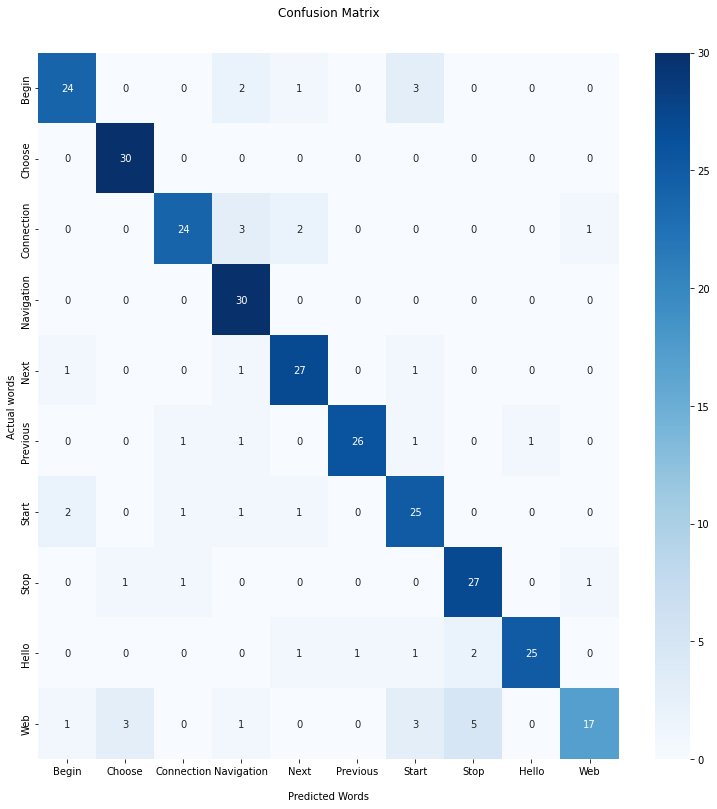

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(13,13))
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Words')
ax.set_ylabel('Actual words');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web'] )
ax.yaxis.set_ticklabels(['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web'] )

## Display the visualization of the Confusion Matrix.
# plt.figure(figsize=(10,9))
plt.show()
fig.savefig('confusion_matrix'+'.jpg')

In [ ]:
print(metrics.classification_report(actual_words, predicted_words,labels=['Begin', 'Choose', 'Connection', 'Navigation', 'Next', 'Previous', 'Start', 'Stop', 'Hello', 'Web']))

              precision    recall  f1-score   support

       Begin       0.86      0.80      0.83        30
      Choose       0.88      1.00      0.94        30
  Connection       0.89      0.80      0.84        30
  Navigation       0.77      1.00      0.87        30
        Next       0.84      0.90      0.87        30
    Previous       0.96      0.87      0.91        30
       Start       0.74      0.83      0.78        30
        Stop       0.79      0.90      0.84        30
       Hello       0.96      0.83      0.89        30
         Web       0.89      0.57      0.69        30

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



In [ ]:
import shutil
colab_link = "/content/cropped"
gdrive_link = "/content/drive/MyDrive"
shutil.copy(colab_link, gdrive_link)

IsADirectoryError: ignored